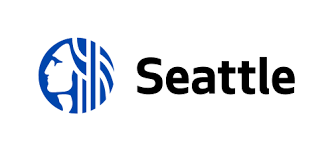

### Anticiper les besoins en consommation de bâtiments - Nettoyage des données et analyse exploratoire

### Sommaire


* [1. Importation des librairies, définition des fonctions et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Définition des fonctions](#1_2)
    * [1.3 Importation du fichier](#1_3)
* [2. Prétraitement des données](#2)
    * [2.1 Visualisation du Dataframe](#2_1)
    * [2.2 Nettoyage des données](#2_2)
        * [2.2.1 Vérification des doublons](#2_2_1)
        * [2.2.2 Suppression des bâtiments destinés à l'habitation](#2_2_2)
        * [2.2.3 Nettoyage des autres variables de type objet](#2_2_3)
        * [2.2.4 Outliers, ComplianceStatus et DefaultData](#2_2_4)
        * [2.2.5 Valeurs manquantes](#2_2_5)
* [3. Feature engineering](#3)
    * [3.1 Variables cibles - TARGETS](#3_1)
    * [3.2 Choix des variables](#3_2)
    * [3.3 Création d'une variable 'EraBuild' pour l'époque de construction](#3_3)
    * [3.4 Création d'un ratio d'utilisation pour SteamUse, Electricity et NaturalGas](#3_4)
    * [3.5 Identification des variables catégorielles](#3_5)
* [4. Analyse exploratoire](#4)
    * [4.1 Distribution des variables quantitatives](#4_1)
    * [4.2 Distribution des variables target](#4_2)
    * [4.3 Répartition des variables catégorielles](#4_3)
    * [4.4 Matrice des corrélations](#4_4)
* [5. Export du fichier csv](#5)

## 1. Importation des librairies, définition des fonctions et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# data
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Définition des fonctions <a class="anchor" id="1_2"></a>

In [2]:
def frequences(df):
    """Comptabiliser les modalités des variables catégorielles"""
    for colonne in df.columns:
        if (df[colonne].dtype == 'object'):
            print(df[colonne].value_counts())
            print('-----------------------------------------------------------------')
            
def pourcentage(df):
    """Fonction permettant de visualiser le taux de valeurs manquantes par variables dans un dataframe"""
    pourcentage_valeurs_manquantes = (df.isna().sum() / len(df)) * 100
    df_pourcentage_manquant = pd.DataFrame({'Nom de la colonne': pourcentage_valeurs_manquantes.index,
                                            'Pourcentage de valeurs manquantes': pourcentage_valeurs_manquantes.values})
    df_pourcentage_manquant = df_pourcentage_manquant.sort_values('Pourcentage de valeurs manquantes', ascending=False)
    df_pourcentage_manquant = df_pourcentage_manquant.loc[df_pourcentage_manquant['Pourcentage de valeurs manquantes'] \
                                                         != 0].reset_index(drop=True)
    return df_pourcentage_manquant

def époque(year):
    """Fonction pour déterminer l'époque de construction du bâtiment"""
    if year <= 1910:
        return 1900
    elif (year > 1910) & (year <= 1920):
        return 1910
    elif (year > 1920) & (year <= 1930):
        return 1920
    elif (year > 1930) & (year <= 1940):
        return 1930
    elif (year > 1940) & (year <= 1950):
        return 1940
    elif (year > 1950) & (year <= 1960):
        return 1950
    elif (year > 1960) & (year <= 1970):
        return 1960
    elif (year > 1970) & (year <= 1980):
        return 1970
    elif (year > 1980) & (year <= 1990):
        return 1980
    elif (year > 1990) & (year <= 2000):
        return 1990
    elif (year > 2000) & (year <= 2010):
        return 2000
    elif (year > 2010) & (year <= 2020):
        return 2010

### 1.3 Importation du fichier <a class="anchor" id="1_3"></a>

In [3]:
df_data = pd.read_csv('2016_Building_Energy_Benchmarking.csv', delimiter=',')

## 2. Prétraitement des données <a class="anchor" id="2"></a>

### 2.1 Visualisation du Dataframe <a class="anchor" id="2_1"></a>

In [4]:
# Visualiser les 5 premières lignes du Dataframe
pd.set_option("display.max_columns", None) # Pour afficher toutes les colonnes
df_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [5]:
# Vérification du contenu du dataframe et du type de données
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### **Définition des variables** : 

On peut retrouver la description de chaque variable sur : 
https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

**OSEBuildingID** : Identifiant unique attribué à chaque propriété couverte par l'ordonnance de Benchmarking de Seattle à des fins de suivi et d'identification.

**DataYear** : Année civile (de janvier à décembre) représentée par chaque enregistrement de données.

**BuildingType** : Classification du type de bâtiment de la ville de Seattle.

**PrimaryPropertyType** : L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). L'utilisation principale est définie comme une fonction qui représente plus de 50 % d'une propriété. Il s'agit du champ Property Type calculé par l'EPA à partir de Portfolio Manager.

**PropertyName** : Nom officiel ou courant de la propriété tel qu'il est saisi dans le Portfolio Manager de l'EPA.

**Address** : Adresse de la rue de la propriété.

**City** : Ville de la propriété.

**State** : État de la propriété.

**ZipCode** : Code postal de la propriété.

**TaxParcelIdentificationNumber** : Numéro d'identification de parcelle du comté de King de la propriété.

**CouncilDistrictCode** : Code du district du conseil de la ville de Seattle de la propriété.

**Neighborhood** : Zone de voisinage de la propriété définie par le département des quartiers de la ville de Seattle.

**Latitude** : Latitude de la propriété.

**Longitude** : Longitude de la propriété.

**YearBuilt** : Année de construction de la propriété ou année de rénovation complète.

**NumberofBuildings** : Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est rapportée comme un campus, plusieurs bâtiments peuvent être inclus dans un seul rapport.

**NumberofFloors** : Nombre d'étages rapportés dans le Portfolio Manager.

**PropertyGFATotal** : Surface brute totale du bâtiment et du parking.

**PropertyGFAParking** : Espace total en pieds carrés de tous les types de stationnement (entièrement clos, partiellement clos et ouvert).

**PropertyGFABuilding(s)** : Espace au sol total en pieds carrés entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela inclut toutes les zones à l'intérieur du ou des bâtiments, telles que les espaces des locataires, les parties communes, les cages d'escalier, les sous-sols, les espaces de stockage, etc.

**ListOfAllPropertyUseTypes** : Toutes les utilisations de propriété rapportées dans le Portfolio Manager.

**LargestPropertyUseType** : La plus grande utilisation d'une propriété (par exemple, bureau, magasin de détail) en termes de surface brute.

**LargestPropertyUseTypeGFA** : La surface brute (GFA) de la plus grande utilisation de la propriété.

**SecondLargestPropertyUseType** : La deuxième plus grande utilisation d'une propriété (par exemple, bureau, magasin de détail) en termes de surface brute.

**SecondLargestPropertyUseTypeGFA** : La surface brute (GFA) de la deuxième plus grande utilisation de la propriété.

**ThirdLargestPropertyUseType** : La troisième plus grande utilisation d'une propriété (par exemple, bureau, magasin de détail) en termes de surface brute.

**ThirdLargestPropertyUseTypeGFA** : La surface brute (GFA) de la troisième plus grande utilisation de la propriété.

**YearsENERGYSTARCertified** : Années où la propriété a reçu la certification ENERGY STAR.

**ENERGYSTARScore** : Une note calculée par l'EPA de 1 à 100 qui évalue la performance énergétique globale d'une propriété, basée sur des données nationales pour tenir compte des différences liées au climat, à l'utilisation des bâtiments et aux opérations. Une note de 50 représente la médiane nationale.

**SiteEUI(kBtu/sf)** : Intensité de l'utilisation d'énergie sur site (EUI) est l'utilisation d'énergie sur site d'une propriété divisée par sa surface brute. L'utilisation d'énergie sur site est la quantité annuelle de toute l'énergie consommée par la propriété sur place, telle que rapportée sur les factures d'électricité. L'EUI sur site est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.

**SiteEUIWN(kBtu/sf)** : Intensité de l'utilisation d'énergie sur site normalisée aux conditions météorologiques (WN) est l'utilisation d'énergie sur site normalisée de la propriété divisée par sa surface brute (en pieds carrés). L'utilisation d'énergie sur site normalisée est l'utilisation d'énergie sur site que la propriété aurait consommée lors de conditions météorologiques moyennes sur 30 ans. L'EUI sur site WN est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.

**SourceEUI(kBtu/sf)** : Intensité de l'utilisation d'énergie source (EUI) est l'utilisation d'énergie source d'une propriété divisée par sa surface brute. L'utilisation d'énergie source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de génération, de transmission et de distribution. L'EUI source est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.

**SourceEUIWN(kBtu/sf)** : Intensité de l'utilisation d'énergie source normalisée aux conditions météorologiques (WN) est l'utilisation d'énergie source normalisée de la propriété divisée par sa surface brute (en pieds carrés). L'utilisation d'énergie source normalisée est l'utilisation d'énergie source que la propriété aurait consommée lors de conditions météorologiques moyennes sur 30 ans. L'EUI source WN est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.

**SiteEnergyUse(kBtu)** : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.

**SiteEnergyUseWN(kBtu)** : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé lors de conditions météorologiques moyennes sur 30 ans.

**SteamUse(kBtu)** : La quantité annuelle de vapeur de quartier consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).

**Electricity(kWh)** : La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée au réseau et produite par des systèmes d'énergie renouvelable sur place, mesurée en kWh.

**Electricity(kBtu)** : La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée au réseau et produite par des systèmes d'énergie renouvelable sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).

**NaturalGas(therms)** : La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en thermies.

**NaturalGas(kBtu)** : La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en milliers d'unités thermiques britanniques (kBtu).

**DefaultData** : La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.

**Comments** : Commentaires d'un propriétaire de bâtiment ou d'un agent pour fournir un contexte sur l'utilisation de l'énergie du bâtiment.

**ComplianceStatus** : Si une propriété a satisfait aux exigences de benchmarking énergétique pour l'année de déclaration en cours.

**Outlier** : Si une propriété est un cas exceptionnel élevé ou bas (O/N).

**TotalGHGEmissions** : Le montant total des émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz à l'oxyde nitreux libérés dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesuré en tonnes métriques d'équivalent de dioxyde de carbone. Ce calcul utilise un facteur d'émissions de gaz à effet de serre provenant de la liste de ressources de génération de Seattle City Light. Il utilise un facteur d'émissions de 52,44 livres de CO2e/MWh de Seattle City Light jusqu'à ce que le facteur de 2016 soit disponible. Le facteur de vapeur d'Enwave = 170,17 livres de CO2e/MMBtu. Le facteur de gaz provient de l'EPA Portfolio Manager = 53,11 kg de CO2e/MBtu.

**GHGEmissionsIntensity** : Total des émissions de gaz à effet de serre divisé par la surface brute de la propriété, mesuré en kilogrammes d'équivalent de dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de gaz à effet de serre provenant de la liste de ressources de génération de Seattle City Light.

### 2.2 Nettoyage des données <a class="anchor" id="2_2"></a>

#### 2.2.1 Vérification des doublons <a class="anchor" id="2_2_1"></a>

In [6]:
# Check des doublons
if df_data.duplicated().sum() > 0:
    print('Le nombre de doublons présents dans le Dataframe est de : ', df_data.duplicated().sum())
else:
    print('Pas de doublons présents dans le Dataframe.')

Pas de doublons présents dans le Dataframe.


#### 2.2.2 Suppression des bâtiments destinés à l'habitation <a class="anchor" id="2_2_2"></a>

Nous nous interressons aux bâtiments non destinés à l'habitation. Regardons donc les données que nous avons dans les variables :
* BuildingType
* PrimaryPropertyType

In [7]:
# Regardons les valeurs uniques que contient la colonne 'BuldingType'
Building_Type = df_data.BuildingType.unique().tolist()
Building_Type

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Campus',
 'Multifamily LR (1-4)',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [8]:
# Liste des Building_Type à supprimer
Building_Residential = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']

# Suppression des bâtiments destinés à l'habitation
df_data = df_data[~df_data['BuildingType'].isin(Building_Residential)].reset_index(drop=True)

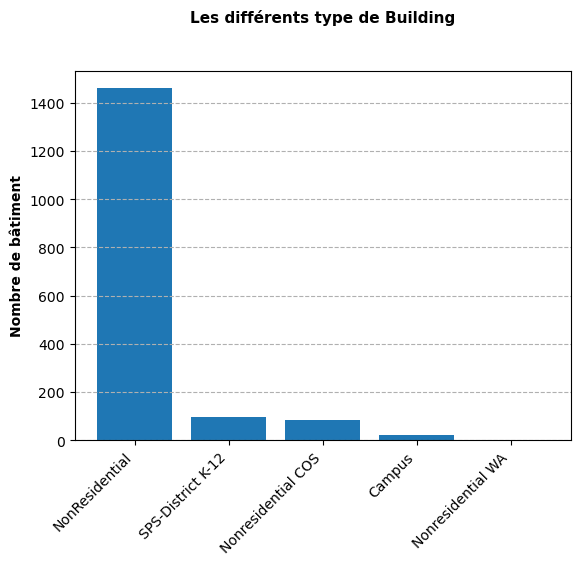

In [9]:
# Compter le nombre de bâtiments par type de BuildingType
counts = df_data['BuildingType'].value_counts()

# Création d'un diagramme en barre
plt.bar(counts.index, counts)
plt.title('Les différents type de Building', pad=35, fontsize=11, fontweight='bold')
plt.ylabel('Nombre de bâtiment', fontweight='bold')
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')

Maintenant tous les BuildingType sont NonResidential, nous pouvons modifier et mettre une seule valeur : 'NonResidential'.

In [10]:
# Modifions les valeurs non spécifiées 'NonResidential'
df_data['BuildingType'] = df_data['BuildingType'].replace(['Nonresidential COS', 'SPS-District K-12',
                                                          'Campus', 'Nonresidential WA'], 'NonResidential')

In [11]:
# Vérifions les valeurs uniques des PrimaryPropertyType
Primary_PropertyType = df_data.PrimaryPropertyType.unique().tolist()
Primary_PropertyType

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'University',
 'Small- and Mid-Sized Office',
 'Self-Storage Facility',
 'Warehouse',
 'Large Office',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital',
 'Residence Hall',
 'Distribution Center',
 'Worship Facility',
 'Supermarket / Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Low-Rise Multifamily',
 'Office']

In [12]:
# Nombre de valeurs pour les PrimaryPropertyType
df_data.PrimaryPropertyType.value_counts()

Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

Il semble que certains Low-Rise Multifamily n'est pas été bien répertoriés. Supprimons ces 3 lignes restantes.

In [13]:
# Supprimons Low-Rise Multifamily de la liste Primary_PropertyType
Primary_PropertyType.remove('Low-Rise Multifamily')

# Dataframe sans Low-Rise Multifamily
df_data = df_data[df_data['PrimaryPropertyType'].isin(Primary_PropertyType)].reset_index(drop=True)

In [14]:
# Vérifions les dimensions
print('Dimension du jeu de données :', df_data.shape)

Dimension du jeu de données : (1665, 46)


#### 2.2.3 Nettoyage des autres variables de type objet <a class="anchor" id="2_2_3"></a>

In [15]:
# Vérification des modalités
frequences(df_data)

NonResidential    1665
Name: BuildingType, dtype: int64
-----------------------------------------------------------------
Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64
-----------------------------------------------------------------
South Park                     2
Cana

##### Les arrondissements (Neighborhood)

On peut voir que certaines valeurs ne semblent pas correctement écrites pour la variable Neighborhood.

In [16]:
# Affichons les valeurs uniques présentes dans Neighborhood
df_data['Neighborhood'].value_counts(ascending=False)

DOWNTOWN                  360
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                147
NORTHEAST                 128
EAST                      120
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

En effet, toutes les valeurs dont le nombre est inférieur à 10 doivent être réécrites correctement.

In [17]:
# Remplaçons les valeurs incorrectes
remplacement = {'North': 'NORTH', 'Ballard': 'BALLARD', 'Central': 'CENTRAL', 
                'Northwest': 'NORTHWEST', 'Delridge': 'DELRIDGE', 'DELRIDGE NEIGHBORHOODS': 'DELRIDGE'}

df_data['Neighborhood'] = df_data['Neighborhood'].replace(remplacement)

# Vérifions la modification
df_data['Neighborhood'].value_counts(ascending=False)

DOWNTOWN                 360
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               147
NORTHEAST                128
EAST                     120
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   56
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
Name: Neighborhood, dtype: int64

##### Les types d'immeuble (PrimaryPropertyType)

In [18]:
df_data['PrimaryPropertyType'].value_counts(ascending=False)

Small- and Mid-Sized Office    292
Other                          250
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [19]:
# Créer un dictionnaire de remplacement
regroupement = {
    'Small- and Mid-Sized Office': 'Office',
    'Large Office': 'Office',
    'Warehouse': 'Storage',
    'Self-Storage Facility': 'Storage',
    'Refrigerated Warehouse': 'Storage',
    'Mixed Use Property': 'Store',
    'Retail Store': 'Store',
    'Distribution Center': 'Store',
    'Supermarket / Grocery Store': 'Store',
    'Hotel': 'HotelResidence',
    'Residence Hall' : 'HotelResidence',
    'K-12 School': 'Education', 
    'University': 'Education',
    'Medical Office': 'Medical',
    'Hospital': 'Medical',
    'Laboratory': 'Medical'
}

# Utiliser le dictionnaire pour effectuer le remplacement
df_data['PrimaryPropertyType'] = df_data['PrimaryPropertyType'].replace(regroupement)

# Vérification
df_data['PrimaryPropertyType'].value_counts(ascending=False)

Office                   468
Store                    298
Other                    250
Storage                  227
Education                163
HotelResidence            97
Worship Facility          71
Medical                   59
Senior Care Community     20
Restaurant                12
Name: PrimaryPropertyType, dtype: int64

##### Les utilisations des immeubles (LargestPropertyUseType)

In [20]:
df_data['LargestPropertyUseType'].value_counts(ascending=False)

Office                                                  497
Non-Refrigerated Warehouse                              199
K-12 School                                             139
Retail Store                                             99
Other                                                    98
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                   

In [21]:
# Créer un dictionnaire de regroupement
regroupement = {
    'Office': 'Office',
    'Non-Refrigerated Warehouse': 'Warehouse',
    'K-12 School': 'Education',
    'Retail Store': 'Store',
    'Other': 'Other',
    'Hotel': 'HotelResidence',
    'Worship Facility': 'Other',
    'Distribution Center': 'Store',
    'Supermarket/Grocery Store': 'Store',
    'Medical Office': 'Medical',
    'Other - Recreation': 'Other',
    'Parking': 'Other',
    'Self-Storage Facility': 'Warehouse',
    'College/University': 'Education',
    'Residence Hall/Dormitory': 'Education',
    'Other - Entertainment/Public Assembly': 'Other',
    'Senior Care Community': 'Other',
    'Laboratory': 'Medical',
    'Restaurant': 'Restaurant',
    'Refrigerated Warehouse': 'Warehouse',
    'Hospital (General Medical & Surgical)': 'Medical',
    'Social/Meeting Hall': 'Other',
    'Multifamily Housing': 'Residential',
    'Manufacturing/Industrial Plant': 'Warehouse',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Other',
    'Strip Mall': 'Store',
    'Museum': 'Other',
    'Automobile Dealership': 'Store',
    'Other - Services': 'Other',
    'Other - Lodging/Residential': 'Residential',
    'Fitness Center/Health Club/Gym': 'Other',
    'Other - Education': 'Education',
    'Urgent Care/Clinic/Other Outpatient': 'Medical',
    'Library': 'Other',
    'Bank Branch': 'Office',
    'Other - Mall': 'Store',
    'Financial Office': 'Office',
    'Other/Specialty Hospital': 'Medical',
    'Performing Arts': 'Other',
    'Prison/Incarceration': 'Other',
    'Data Center': 'Other',
    'Lifestyle Center': 'Other',
    'Other - Public Services': 'Other',
    'Other - Restaurant/Bar': 'Restaurant',
    'Adult Education': 'Education',
    'Other - Utility': 'Other',
    'Pre-school/Daycare': 'Education',
    'Wholesale Club/Supercenter': 'Store',
    'Convention Center': 'Other',
    'Fire Station': 'Other',
    'Residential Care Facility': 'Residential',
    'Police Station': 'Other',
    'Food Service': 'Restaurant',
    'Movie Theater': 'Other',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Other',
    'Courthouse': 'Other'
}

# Utiliser le dictionnaire pour effectuer le regroupement
df_data['LargestPropertyUseType'] = df_data['LargestPropertyUseType'].replace(regroupement)

# Vérifions
df_data['LargestPropertyUseType'].value_counts(ascending=False)

Office            505
Other             327
Warehouse         246
Store             210
Education         193
HotelResidence     76
Medical            72
Residential        15
Restaurant         15
Name: LargestPropertyUseType, dtype: int64

##### Les utilisations des immeubles (SecondLargestPropertyUseType)

In [22]:
df_data['SecondLargestPropertyUseType'].value_counts(ascending=False)

Parking                                                 336
Office                                                  167
Retail Store                                             84
Other                                                    45
Non-Refrigerated Warehouse                               30
Restaurant                                               29
Fitness Center/Health Club/Gym                           16
Data Center                                              13
Multifamily Housing                                      12
Other - Services                                         11
Supermarket/Grocery Store                                10
Laboratory                                                8
Medical Office                                            8
Bank Branch                                               7
Other - Entertainment/Public Assembly                     7
Distribution Center                                       7
K-12 School                             

In [23]:
# Créer un dictionnaire de regroupement
regroupement_second_largest = {
    'Parking': 'Parking',
    'Office': 'Office',
    'Retail Store': 'Store',
    'Other': 'Other',
    'Non-Refrigerated Warehouse': 'Warehouse',
    'Restaurant': 'Restaurant',
    'Fitness Center/Health Club/Gym': 'Other',
    'Data Center': 'Other',
    'Multifamily Housing': 'Residential',
    'Other - Services': 'Other',
    'Supermarket/Grocery Store': 'Store',
    'Laboratory': 'Medical',
    'Medical Office': 'Medical',
    'Bank Branch': 'Office',
    'Other - Entertainment/Public Assembly': 'Other',
    'Distribution Center': 'Store',
    'K-12 School': 'Education',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Other',
    'Other - Recreation': 'Other',
    'Swimming Pool': 'Other',
    'Self-Storage Facility': 'Warehouse',
    'Other - Public Services': 'Other',
    'Worship Facility': 'Other',
    'Hotel': 'HotelResidence',
    'Movie Theater': 'Other',
    'Bar/Nightclub': 'Other',
    'Food Sales': 'Restaurant',
    'Refrigerated Warehouse': 'Warehouse',
    'Other - Education': 'Education',
    'Manufacturing/Industrial Plant': 'Warehouse',
    'Automobile Dealership': 'Store',
    'Adult Education': 'Education',
    'Other - Restaurant/Bar': 'Restaurant',
    'Performing Arts': 'Other',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Other',
    'Financial Office': 'Office',
    'Enclosed Mall': 'Store',
    'Other - Lodging/Residential': 'Residential',
    'College/University': 'Education',
    'Convenience Store without Gas Station': 'Store',
    'Courthouse': 'Other',
    'Residence Hall/Dormitory': 'Education',
    'Food Service': 'Restaurant',
    'Pre-school/Daycare': 'Education',
    'Social/Meeting Hall': 'Other',
    'Hospital (General Medical & Surgical)': 'Medical',
    'Vocational School': 'Education'
}

# Utiliser le dictionnaire pour effectuer le regroupement
df_data['SecondLargestPropertyUseType'] = df_data['SecondLargestPropertyUseType'].replace(regroupement_second_largest)

# Vérifions
df_data['SecondLargestPropertyUseType'].value_counts(ascending=False)

Parking           336
Office            175
Other             120
Store             105
Warehouse          37
Restaurant         34
Medical            17
Education          13
Residential        13
HotelResidence      3
Name: SecondLargestPropertyUseType, dtype: int64

##### Les utilisations des immeubles (ThirdLargestPropertyUseType)

In [24]:
df_data['ThirdLargestPropertyUseType'].value_counts(ascending=False)

Office                                                  49
Retail Store                                            48
Parking                                                 46
Other                                                   39
Restaurant                                              31
Non-Refrigerated Warehouse                              15
Data Center                                             14
Multifamily Housing                                     12
Swimming Pool                                           10
Medical Office                                           9
Social/Meeting Hall                                      8
Food Service                                             8
Pre-school/Daycare                                       8
Bank Branch                                              5
Other - Restaurant/Bar                                   5
Financial Office                                         4
Fitness Center/Health Club/Gym                          

In [25]:
# Créer un dictionnaire de regroupement
regroupement_third_largest = {
    'Office': 'Office',
    'Retail Store': 'Store',
    'Parking': 'Parking',
    'Other': 'Other',
    'Restaurant': 'Restaurant',
    'Non-Refrigerated Warehouse': 'Warehouse',
    'Data Center': 'Other',
    'Multifamily Housing': 'Residential',
    'Swimming Pool': 'Other',
    'Medical Office': 'Medical',
    'Social/Meeting Hall': 'Other',
    'Food Service': 'Restaurant',
    'Pre-school/Daycare': 'Education',
    'Bank Branch': 'Office',
    'Other - Restaurant/Bar': 'Restaurant',
    'Financial Office': 'Office',
    'Fitness Center/Health Club/Gym': 'Other',
    'Other - Entertainment/Public Assembly': 'Other',
    'Distribution Center': 'Store',
    'Refrigerated Warehouse': 'Warehouse',
    'Other - Technology/Science': 'Other',
    'Self-Storage Facility': 'Warehouse',
    'K-12 School': 'Education',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Other',
    'Other - Recreation': 'Other',
    'Laboratory': 'Medical',
    'Other - Education': 'Education',
    'Other - Services': 'Other',
    'Convenience Store without Gas Station': 'Store',
    'Hotel': 'HotelResidence',
    'Other - Utility': 'Other',
    'Bar/Nightclub': 'Restaurant',
    'Manufacturing/Industrial Plant': 'Warehouse',
    'Other/Specialty Hospital': 'Medical',
    'Fast Food Restaurant': 'Restaurant',
    'Worship Facility': 'Other',
    'Supermarket/Grocery Store': 'Store',
    'Strip Mall': 'Store',
    'Vocational School': 'Education'
}

# Utiliser le dictionnaire pour effectuer le regroupement
df_data['ThirdLargestPropertyUseType'] = df_data['ThirdLargestPropertyUseType'].replace(regroupement_third_largest)

# Vérifions
df_data['ThirdLargestPropertyUseType'].value_counts(ascending=False)

Other             89
Office            58
Store             55
Restaurant        46
Parking           46
Warehouse         20
Education         13
Medical           12
Residential       12
HotelResidence     1
Name: ThirdLargestPropertyUseType, dtype: int64

#### 2.2.4 Outliers, ComplianceStatus et DefaultData <a class="anchor" id="2_2_4"></a>

Les trois colonnes en question nous indiquent que certaines lignes ne sont pas complètes, présentent des défauts de données ou qu'elles sont des valeurs aberrantes. Nous allons donc examiner leur contenu.

In [26]:
# Regardons les outliers dans la colonne 'Outlier'
df_data.loc[df_data['Outlier'].notnull()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
220,350,2016,NonResidential,Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,Other,39336.0,Parking,25000.0,NaN,NaN,297.399994,299.200012,909.599976,911.500000,4.139950e+07,4.165040e+07,0.0,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
378,539,2016,NonResidential,Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,Store,69800.0,Other,0.0,NaN,NaN,NaN,100.0,4.600000,4.600000,14.300000,14.300000,3.189628e+05,3.189628e+05,0.0,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
442,608,2016,NonResidential,Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,Office,193154.0,NaN,NaN,NaN,NaN,NaN,100.0,58.000000,58.799999,28.000000,28.700001,1.119592e+07,1.134876e+07,0.0,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19
507,704,2016,NonResidential,Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.0,7666202110,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.0,Parking,42500.0,Other,4778.0,NaN,1.0,311.700012,311.700012,978.900024,978.900024,2.713719e+07,2.713719e+07,0.0,7.953454e+06,27137187.0,0.000000,0.0,False,NaN,Non-Compliant,High outlier,189.18,1.46
697,19967,2016,NonResidential,Education,Queen Anne Gym,1431 2nd Ave N,Seattle,WA,98109.0,0811000005,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1.0,1,35805,0,35805,K-12 School,Education,35805.0,NaN,NaN,NaN,NaN,NaN,100.0,12.100000,12.100000,27.000000,27.000000,4.314717e+05,4.314717e+05,0.0,7.228240e+04,246628.0,1848.439575,184844.0,True,NaN,Error - Correct Default Data,Low outlier,11.54,0.32
776,20617,2016,NonResidential,Store,Seattle Habitat Store,21 S Nevada St,Seattle,WA,98134.0,1824049074,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,39900,0,39900,"Non-Refrigerated Warehouse, Retail Store",Store,25000.0,Warehouse,15000.0,NaN,NaN,NaN,100.0,3.600000,3.600000,6.400000,6.400000,1.454688e+05,1.454688e+05,0.0,1.436250e+04,49005.0,964.640015,96464.0,True,NaN,Error - Correct Default Data,Low outlier,5.46,0.14
867,21315,2016,NonResidential,Office,1518 Fifith Ave,1520 Fifth Ave,Seattle,WA,98101.0,1975700135,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,57720,0,57720,Office,Office,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,3.000000,3.000000,2.410550e+04,2.410550e+04,0.0,7.064900e+03,24105.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.17,0.00
909,21474,2016,NonResidential,Other,The Lusty Lady,1315 1st Ave,Seattle,WA,98101.0,1976200060,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,Other,24019.0,NaN,NaN,NaN,NaN,NaN,NaN,1.800000,1.800000,5.800000,5.800000,4.429350e+04,4.429350e+04,0.0,1.298170e+04,44294.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.31,0.01
1031,22830,2016,NonResidential,Worship Facility,Freedom Church,9601 35th Ave,Seattle,WA,98126.0,28

In [27]:
# Supprimer les outliers
df_data = df_data.loc[df_data['Outlier'].isnull()].reset_index(drop=True)

In [28]:
# Regardons de quoi est composée la variables 'ComplianceStatus'
df_data.ComplianceStatus.value_counts()

Compliant                       1546
Error - Correct Default Data      86
Missing Data                      14
Non-Compliant                      3
Name: ComplianceStatus, dtype: int64

In [29]:
# Gardons seulement les valeurs 'Compliant'
df_data = df_data.loc[df_data['ComplianceStatus'] == 'Compliant'].reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_data.shape)

Dimension du jeu de données : (1546, 46)


In [30]:
# Regardons de quoi est composée la variables 'DefaultData'
df_data.DefaultData.value_counts()

False    1546
Name: DefaultData, dtype: int64

##### Describe

Regardons maintenant un describe pour voir si certaines valeurs aberrantes sont présentes ou non dans le Dataframe.

In [31]:
# Describe
df_data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1546.000000,1546.0,1533.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1.546000e+03,1546.000000,1.546000e+03,1.542000e+03,841.000000,347.000000,996.000000,1546.000000,1545.000000,1546.000000,1546.000000,1.546000e+03,1.545000e+03,1.546000e+03,1.546000e+03,1.546000e+03,1.546000e+03,1.546000e+03,0.0,1546.000000,1546.000000
mean,16492.815006,2016.0,98116.795825,4.413972,47.616472,-122.333513,1961.631953,1.179172,4.277490,1.213994e+05,13836.898448,1.075625e+05,1.000015e+05,36373.279782,15031.542936,63.667671,75.111966,77.556181,183.239845,185.384929,8.867785e+06,8.449111e+06,5.518961e+05,1.801059e+06,6.145212e+06,2.040770e+04,2.040770e+06,NaN,193.825776,1.668959
std,13836.040087,0.0,18.700105,2.191933,0.046977,0.023278,32.889927,3.041181,6.784999,3.064857e+05,43745.031804,2.928095e+05,2.856797e+05,66664.811355,37085.481296,28.822329,75.248895,76.271544,188.050626,188.080848,3.132518e+07,2.279062e+07,5.722168e+06,6.308399e+06,2.152426e+07,9.716705e+04,9.716705e+06,NaN,779.586028,2.408717
min,1.000000,2016.0,98006.000000,1.000000,47.509590,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,1.400000,0.000000,0.000000,-2.100000,5.713320e+04,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,602.250000,2016.0,98104.000000,2.000000,47.587825,-122.343093,1930.000000,1.000000,1.000000,2.884175e+04,0.000000,2.793425e+04,2.503975e+04,5561.000000,2613.500000,44.000000,34.900002,37.000000,81.249998,84.325003,1.248602e+06,1.321763e+06,0.000000e+00,2.139610e+05,7.300348e+05,0.000000e+00,0.000000e+00,NaN,20.645000,0.360000
50%,21180.500000,2016.0,98109.000000,4.000000,47.612710,-122.333160,1965.500000,1.000000,2.000000,4.815900e+04,0.000000,4.608400e+04,4.204300e+04,12102.000000,6000.000000,71.000000,53.750000,56.299999,138.650002,141.800003,2.732167e+06,2.824097e+06,0.000000e+00,5.109501e+05,1.743362e+06,4.906580e+03,4.906580e+05,NaN,49.940000,0.885000
75%,24619.000000,2016.0,98125.000000,7.000000,47.649080,-122.322660,1989.000000,1.000000,4.000000,1.078405e+05,0.000000,9.585275e+04,9.209825e+04,31845.000000,12990.000000,88.000000,85.174997,87.900002,213.349995,215.674999,7.301812e+06,7.483350e+06,0.000000e+00,1.543338e+06,5.265868e+06,1.531061e+04,1.531061e+06,NaN,147.402500,1.960000
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.261800,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,639931.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


Nous observons plusieurs valeurs atypiques dans les données :

* Le nombre de bâtiments ('NumberofBuildings') présente un minimum de 0 et un maximum de 111.
* Le nombre d'étages ('NumberofFloors') a un minimum de 0 et un maximum de 99.
* La consommation d'électricité ('Electricity(kBtu)') contient des valeurs négatives.
* Le total des émissions de gaz à effet de serre ('TotalGHGEmissions') contient des valeurs négatives.

##### Le nombre de bâtiments ('NumberofBuildings')

In [32]:
# Bâtiments avec un nombre de bâtiments à 0
df_data.loc[df_data['NumberofBuildings'] == 0] 

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
56,89,2016,NonResidential,Medical,Polyclinic North && South,1200 Harvard Ave,Seattle,WA,98122.0,1978201270,3,EAST,47.612440,-122.321400,1965,0.0,3,179014,0,179014,Medical Office,Medical,179014.0,NaN,NaN,NaN,NaN,NaN,48.0,93.300003,92.300003,213.399994,210.300003,1.670106e+07,1.652771e+07,0.000000e+00,2.897563e+06,9886484.0,68145.703130,6814570.0,False,NaN,Compliant,NaN,430.84,2.41
69,113,2016,NonResidential,Office,KCTS9,401 Mercer St,Seattle,WA,98109.0,1988200705,7,MAGNOLIA / QUEEN ANNE,47.623910,-122.348370,1986,0.0,2,66240,2352,63888,"Data Center, Distribution Center, Office, Park...",Office,45900.0,Other,5181.0,Store,4551.0,NaN,NaN,74.900002,75.400002,235.199997,236.600006,4.166306e+06,4.192108e+06,0.000000e+00,1.221074e+06,4166305.0,0.000000,0.0,False,NaN,Compliant,NaN,29.04,0.44
126,257,2016,NonResidential,Storage,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,Seattle,WA,98134.0,7666703020,1,GREATER DUWAMISH,47.575070,-122.357470,1916,0.0,4,79600,0,79600,Non-Refrigerated Warehouse,Warehouse,79600.0,NaN,NaN,NaN,NaN,NaN,34.0,30.299999,30.299999,95.099998,95.099998,2.411402e+06,2.411402e+06,0.000000e+00,7.067415e+05,2411402.0,0.000000,0.0,False,NaN,Compliant,NaN,16.81,0.21
152,322,2016,NonResidential,Office,Cox Media Group Seattle KIRO TV (322),2801 3rd Ave,Seattle,WA,98121.0,0656000005,7,DOWNTOWN,47.617570,-122.351220,1968,0.0,3,100734,26731,74003,Office,Office,100734.0,NaN,NaN,NaN,NaN,NaN,20.0,97.199997,98.199997,305.100006,308.399994,9.788717e+06,9.892566e+06,0.000000e+00,2.868908e+06,9788716.0,0.000000,0.0,False,NaN,Compliant,NaN,68.24,0.68
191,366,2016,NonResidential,Office,University District Office Buiding,1107 NE 45th St,Seattle,WA,98105.0,1142000500,4,NORTHEAST,47.661000,-122.316260,1961,0.0,5,99005,0,99005,Office,Office,79555.0,NaN,NaN,NaN,NaN,NaN,70.0,59.400002,63.000000,137.600006,140.699997,4.728488e+06,5.008124e+06,0.000000e+00,8.391593e+05,2863212.0,18652.765630,1865277.0,False,NaN,Compliant,NaN,119.03,1.20
214,391,2016,NonResidential,Store,Thaw Building,8300 Military Rd South,Seattle,WA,98108.0,0007400015,2,GREATER DUWAMISH,47.528710,-122.294430,1970,0.0,1,88400,0,88400,"Distribution Center, Non-Refrigerated Warehous...",Warehouse,33450.0,Office,29620.0,Store,27715.0,NaN,42.0,48.299999,53.000000,109.000000,113.900002,4.383100e+06,4.811200e+06,0.000000e+00,7.416934e+05,2530658.0,18524.421880,1852442.0,False,NaN,Compliant,NaN,116.03,1.31
227,408,2016,NonResidential,Office,Fourth and Pike Building,1424 4th Ave,Seattle,WA,98101.0,1975700235,7,DOWNTOWN,47.610050,-122.336100,1926,0.0,10,132326,0,132326,"Office, Other, Retail Store",Office,92006.0,Other,12610.0,Store,9835.0,NaN,72.0,52.700001,53.700001,159.800003,163.000000,6.029020e+06,6.146692e+06,3.282471e+05,1.670053e+06,5698221.0,25.510000,2551.0,False,NaN,Compliant,NaN,65.20,0.49
229,410,2016,NonResidential,HotelResidence,Motif Seattle,1414 4th Ave,Seattle,WA,98101.0,1975700255,7,DOWNTOWN,47.609960,-122.335720,1973,0.0,19,332067,59280,272787,Hotel,HotelResidence,332067.0,NaN,NaN,NaN,NaN,NaN,6.0,113.800003,114.400002,251.300003,249.300003,3.778555e+07,3.798415e+07,1.558601e+07,5.803207e+06,19800542.0,23989.949220,2398995.0,False,NaN,Compliant,NaN,1468.50,4.42
240

In [33]:
# Nombre de bâtiments concernées
nb_bâtiments = df_data.loc[df_data['NumberofBuildings'] == 0]['NumberofBuildings'].count()
print(f'Il y a {nb_bâtiments} bâtiments concernés.')

Il y a 52 bâtiments concernés.


On va supprimer ces bâtiments, la donnée est aberrante.

In [34]:
# Supprimez les lignes où 'NumberofBuildings' est égal à 0
df_data = df_data[df_data['NumberofBuildings'] != 0].reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_data.shape)

Dimension du jeu de données : (1494, 46)


In [35]:
# Bâtiments avec un nombre de bâtiments supérieur à 90
df_data.loc[df_data['NumberofBuildings'] > 90] 

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1456,49967,2016,NonResidential,Education,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,4,NORTHEAST,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156,College/University,Education,9320156.0,NaN,NaN,NaN,NaN,NaN,NaN,93.800003,0.0,246.600006,0.0,873923712.0,0.0,84985240.0,192577488.0,657074389.0,0.0,0.0,False,NaN,Compliant,NaN,11140.56,1.2


Il s'agit de l'Université, cette valeur est atypique mais pas aberrante.

##### Le nombre d'étages ('NumberofFloors')

In [36]:
# Bâtiments avec un nombre d'étage à 0
df_data.loc[df_data['NumberofFloors'] == 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
127,267,2016,NonResidential,HotelResidence,Grand Hyatt Seattle,721 Pine St,Seattle,WA,98101.0,6792120000,7,DOWNTOWN,47.61275,-122.33330,1999,1.0,0,934292,0,934292,"Hotel, Other, Parking, Restaurant, Retail Store",HotelResidence,495536.0,Parking,438756.0,Restaurant,49700.0,NaN,NaN,117.900002,120.500000,272.899994,278.200012,6.504728e+07,66502836.0,0.0,1.153696e+07,39364114.0,256831.625000,25683162.0,False,NaN,Compliant,NaN,1638.46,1.75
415,656,2016,NonResidential,Medical,Arnold Pavilion,1221 Madison Street,Seattle,WA,98104.0,8725990000,3,EAST,47.60979,-122.32298,2004,1.0,0,225982,0,225982,Medical Office,Medical,200184.0,NaN,NaN,NaN,NaN,NaN,53.0,102.699997,103.699997,246.899994,245.300003,2.056062e+07,20764814.0,7815663.0,3.735333e+06,12744957.0,0.000000,0.0,False,NaN,Compliant,NaN,692.12,3.06
485,758,2016,NonResidential,Other,Pacific Place,600 Pine Street,Seattle,WA,98101.0,6600470000,7,DOWNTOWN,47.61289,-122.33531,1999,1.0,0,947987,0,947987,"Office, Other - Entertainment/Public Assembly,...",Store,561684.0,Other,100000.0,Restaurant,80000.0,NaN,NaN,62.299999,62.099998,195.600006,194.899994,4.651096e+07,46343304.0,0.0,1.363158e+07,46510954.0,0.000000,0.0,False,NaN,Compliant,NaN,324.25,0.34
962,23311,2016,NonResidential,Medical,HART First Hill LLC,1124 Columbia Street,Seattle,WA,98104.0,8590900646,3,EAST,47.60862,-122.32372,1945,1.0,0,274568,0,274568,"Medical Office, Parking",Medical,228133.0,Parking,135954.0,NaN,NaN,NaN,52.0,111.000000,111.199997,235.500000,233.100006,2.531153e+07,25358122.0,13296249.0,3.521476e+06,12015275.0,0.000000,0.0,False,NaN,Compliant,NaN,1110.07,4.04
1042,24086,2016,NonResidential,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,1333 AIRPORT WAY S,Seattle,WA,98134.0,7666203387,2,GREATER DUWAMISH,47.59042,-122.32498,1991,10.0,0,230971,0,230971,"Other, Parking",Other,230970.0,Parking,0.0,NaN,NaN,NaN,NaN,91.000000,96.199997,235.100006,242.199997,2.102229e+07,22230844.0,0.0,4.519276e+06,15419770.0,56025.152340,5602515.0,False,NaN,Compliant,NaN,405.05,1.75
1408,40028,2016,NonResidential,Storage,Sandpoint #5,7561 63rd Ave NE,Seattle,WA,98115.0,0225049077,4,NORTHEAST,47.68454,-122.26235,1940,1.0,0,384772,0,384772,"Non-Refrigerated Warehouse, Office",Warehouse,349953.0,Office,63872.0,NaN,NaN,NaN,69.0,36.700001,39.000000,84.099998,86.500000,1.520676e+07,16139557.0,0.0,2.642108e+06,9014872.0,61918.878910,6191888.0,False,NaN,Compliant,NaN,391.70,1.02
1409,40031,2016,NonResidential,Medical,Sandpoint #25,6222 NE 74th St,Seattle,WA,98115.0,0225049077,4,NORTHEAST,47.68240,-122.26223,1960,1.0,0,30287,0,30287,Medical Office,Medical,28050.0,NaN,NaN,NaN,NaN,NaN,32.0,78.199997,81.300003,217.399994,220.600006,2.193115e+06,2279632.5,0.0,5.320647e+05,1815405.0,3777.100342,377710.0,False,NaN,Compliant,NaN,32.72,1.08
1410,40034,2016,NonResidential,Office,Sandpoint #29,6200 NE 74th ST,Seattle,WA,98115.0,0225049077,4,NORTHEAST,47.68254,-122.26299,1960,1.0,0,21931,0,21931,Office,Office,31845.0,Office,31845.0,NaN,NaN,NaN,32.0,124.000000,134.800003,221.899994,233.300003,3.947209e+06,4292216.0,0.0,4.099035e+05,1398591.0,25486.185550,2548619.0,False,NaN,Compliant,NaN,145.11,6.62
1422,49705,2016,NonResidential,Other,Magnuson,7400 Sand Poi

In [37]:
# Nombre de bâtiments concernées
nb_bâtiments = df_data.loc[df_data['NumberofFloors'] == 0]['NumberofFloors'].count()
print(f'Il y a {nb_bâtiments} bâtiments concernés.')

Il y a 15 bâtiments concernés.


On va supprimer ces bâtiments, la donnée est aberrante.

In [38]:
# Supprimez les lignes où 'NumberofFloors' est égal à 0
df_data = df_data[df_data['NumberofFloors'] != 0].reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_data.shape)

Dimension du jeu de données : (1479, 46)


In [39]:
# Bâtiments avec un nombre d'étages supérieur à 70
df_data.loc[df_data['NumberofFloors'] > 70] 

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
478,775,2016,NonResidential,Office,Columbia Center - 2015,701 5th Avenue,Seattle,WA,98104.0,0942000640,7,DOWNTOWN,47.60454,-122.33072,1985,1.0,76,1952220,319400,1632820,"Office, Parking",Office,1680937.0,Parking,319368.0,NaN,NaN,2017201620152012200920072006,86.0,55.299999,55.099998,167.300003,166.500000,9.293764e+07,9.253726e+07,0.0,25747908.0,87851862.0,50857.63281,5085763.0,False,NaN,Compliant,NaN,882.56,0.45
833,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,5801 Beacon Avenue South,Seattle,WA,98108.0,2124049098,2,GREATER DUWAMISH,47.55072,-122.30265,1977,1.0,99,21948,0,21948,Worship Facility,Other,21948.0,NaN,NaN,NaN,NaN,NaN,80.0,14.900000,14.900000,46.599998,46.599998,3.260012e+05,3.260012e+05,0.0,95545.5,326001.0,0.00000,0.0,False,NaN,Compliant,NaN,2.27,0.10


Nous allons supprimer le bâtiment à 99 étages car cela semble être incohérent.

In [40]:
# Supprimez les lignes où 'NumberofFloors' est égal à 0
df_data = df_data[df_data['NumberofFloors'] != 99].reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_data.shape)

Dimension du jeu de données : (1478, 46)


##### Consommation et émission de gaz à effet de serre négatifs

In [41]:
# Bâtiments avec une consommation électrique < 0
df_data.loc[df_data['Electricity(kBtu)'] < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1426,49784,2016,NonResidential,Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,Office,48159.0,NaN,NaN,NaN,NaN,NaN,100.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,False,NaN,Compliant,NaN,-0.8,-0.02


In [42]:
# Bâtiments avec émission de gaz à effet de serre < 0
df_data.loc[df_data['TotalGHGEmissions'] < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1426,49784,2016,NonResidential,Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,Office,48159.0,NaN,NaN,NaN,NaN,NaN,100.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,False,NaN,Compliant,NaN,-0.8,-0.02


Cette donnée atypique s'explique par la présence de panneaux solaires sur le bâtiment, comme visible sur Google Maps.
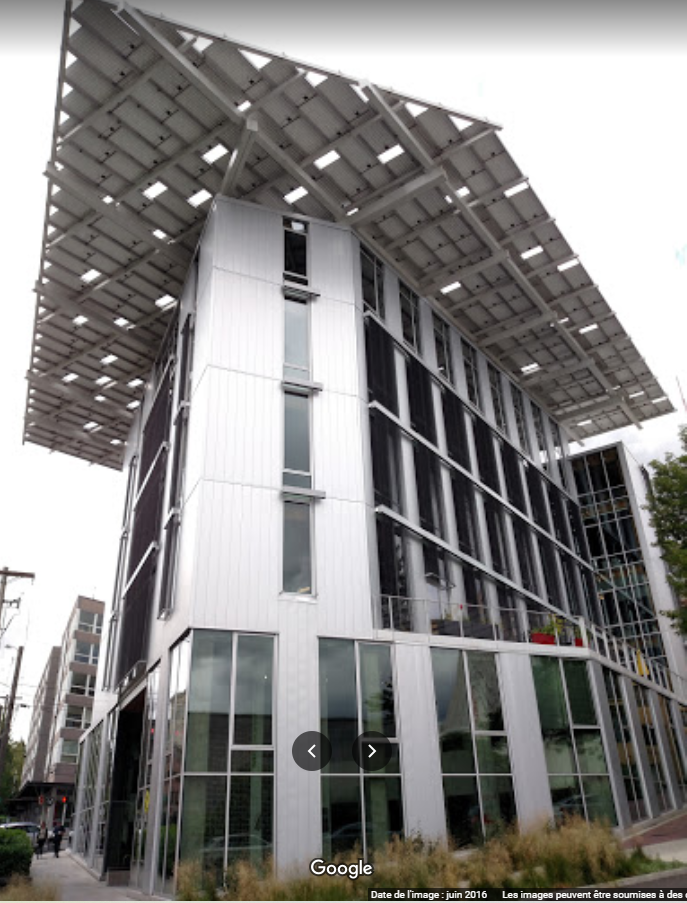

On peut choisir de la supprimer pour ne pas impacter nos prédictions.

In [43]:
# Supprimez la lignes où 'Electricity(kBtu)' et 'TotalGHGEmissions' sont inférieurs à 0
df_data = df_data[df_data['Electricity(kBtu)'] > 0].reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_data.shape)

Dimension du jeu de données : (1475, 46)


#### 2.2.5 Valeurs manquantes <a class="anchor" id="2_2_5"></a>

In [44]:
pourcentage(df_data)

,Nom de la colonne,Pourcentage de valeurs manquantes
0,Outlier,100.000000
1,Comments,100.000000
2,YearsENERGYSTARCertified,93.423729
3,ThirdLargestPropertyUseType,77.966102
4,ThirdLargestPropertyUseTypeGFA,77.966102
5,SecondLargestPropertyUseType,45.559322
6,SecondLargestPropertyUseTypeGFA,45.559322
7,ENERGYSTARScore,34.915254
8,ZipCode,0.881356
9,LargestPropertyUseTypeGFA,0.271186


Regardons les 2ème et 3ème plus large utilisation.

In [45]:
# Nombre de valeurs pour les ThirdLargestPropertyUseType
df_data.ThirdLargestPropertyUseType.unique()

array([nan, 'Restaurant', 'Other', 'Office', 'Store', 'Warehouse',
       'Medical', 'Parking', 'Education', 'Residential'], dtype=object)

In [46]:
# Nombre de valeurs pour les SecondLargestPropertyUseType
df_data.SecondLargestPropertyUseType.unique()

array([nan, 'Parking', 'Office', 'Restaurant', 'Education', 'Medical',
       'Warehouse', 'Store', 'Other', 'Residential', 'HotelResidence'],
      dtype=object)

Il est fortement probable que les valeurs manquantes veulent dire que les bâtiments en question n'ont pas de seconde ou troisième utilisation. On peut également voir que le taux de valeurs manquantes correspond également avec le nombre de mètre carrés correspondant à ces utilisations. 

On va choisir de supprimer ces variables.

In [47]:
# Pour ThirdLargestPropertyUseType
df_data['ThirdLargestPropertyUseType'].fillna('non-existent', inplace=True)

# Pour SecondLargestPropertyUseType
df_data['SecondLargestPropertyUseType'].fillna('non-existent', inplace=True)

# Pour ThirdLargestPropertyUseTypeGFA
df_data['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

# Pour SecondLargestPropertyUseTypeGFA
df_data['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

Pour les valeurs manquantes de la plus large utilisation : 

In [48]:
df_data.loc[df_data['LargestPropertyUseTypeGFA'].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
291,496,2016,NonResidential,Storage,Market St Center,2811 NW Market Street,Seattle,WA,98107.0,1175001235,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,non-existent,0.0,non-existent,0.0,NaN,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,881452.0000,3007514.0,26899.582030,2689958.0,False,NaN,Compliant,NaN,163.83,1.47
723,21103,2016,NonResidential,HotelResidence,Palladian Hotel,2000 Second Avenue,Seattle,WA,98121.0,1977201140,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,non-existent,0.0,non-existent,0.0,NaN,93.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,742846.3750,2534592.0,3624.875244,362488.0,False,NaN,Compliant,NaN,36.92,0.60
1204,25568,2016,NonResidential,Office,Talon Northlake LLC,1341 N Northlake Way,Seattle,WA,98103.0,4088804565,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,NaN,NaN,non-existent,0.0,non-existent,0.0,NaN,45.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,928526.0000,3168131.0,0.000000,0.0,False,NaN,Compliant,NaN,22.09,0.46
1220,25711,2016,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,614 S MAYNARD AVE S,Seattle,WA,98104.0,5247802410,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,non-existent,0.0,non-existent,0.0,NaN,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,118085.2969,402907.0,4970.169922,497017.0,False,NaN,Compliant,NaN,29.21,1.01


Pour ces 4 bâtiments, il s'agit de la surface totale. Remplaçons ces valeurs manquantes :

In [49]:
df_data['LargestPropertyUseTypeGFA'].fillna(df_data['PropertyGFATotal'], inplace=True)
df_data['LargestPropertyUseType'].fillna(df_data['PrimaryPropertyType'], inplace=True)

## 3. Feature engineering <a class="anchor" id="3"></a>

In [50]:
# Vréer une copie du DataFrame original pour le Dataframe nettoyé
df_cleaned = df_data.copy()

### 3.1 Variables cibles - TARGETS <a class="anchor" id="3_1"></a>

Identifions dans un premier temps nos variables cibles 'target'.

In [51]:
# Variable cibles 'TotalGHGEmissions' pour les émissions de gaz à effet de serre 
# et 'SiteEnergyUse(kBtu)' pour la consommation totale d'énergie
df_cleaned.rename(columns={'TotalGHGEmissions': 'TARGET_TotalGHGEmissions',
                       'SiteEnergyUse(kBtu)': 'TARGET_SiteEnergyUse(kBtu)'},
                        inplace=True)

### 3.2 Choix des variables <a class="anchor" id="3_2"></a>

On va pouvoir maintenant supprimer les colonnes qui soit n'apporte pas d'information, soit ne seront pas utiles pour nos modèles de prédictions.

In [52]:
# Affichons le nombre de valeur présentes dans chaque variable
nunique = df_cleaned.nunique()
df_nunique = pd.DataFrame({'Nom de la colonne': nunique.index,
                                            'Nombre de valeur unique': nunique.values})
df_nunique

,Nom de la colonne,Nombre de valeur unique
0,OSEBuildingID,1475
1,DataYear,1
2,BuildingType,1
3,PrimaryPropertyType,10
4,PropertyName,1471
5,Address,1455
6,City,1
7,State,1
8,ZipCode,47
9,TaxParcelIdentificationNumber,1406


In [53]:
# Créer une liste de colonnes à supprimer
colonnes_a_supprimer = []
        
# Alimenter la liste avec les colonnes qui n'apportent pas d'information (soit 0 valeur, soit 1 seule valeur)
df_nunique_1 = df_nunique.loc[df_nunique['Nombre de valeur unique'] <= 1]

for index, row in df_nunique_1.iterrows():
    nom_de_la_colonne = row['Nom de la colonne']
    colonnes_a_supprimer.append(nom_de_la_colonne)
    
# Alimenter la liste avec les colonnes qui n'ont pas d'intérêt pour nos futures prédictions
colonnes_a_supprimer.extend(['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
                           'CouncilDistrictCode', 'Latitude', 'Longitude', 'PropertyGFABuilding(s)', 
                             'ListOfAllPropertyUseTypes','YearsENERGYSTARCertified', 'SiteEUI(kBtu/sf)', 
                             'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 
                             'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)','NaturalGas(therms)', 
                             'ComplianceStatus', 'GHGEmissionsIntensity'])

df_cleaned = df_cleaned.drop(columns=colonnes_a_supprimer).reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_cleaned.shape)

Dimension du jeu de données : (1475, 19)


In [54]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1475 non-null   object 
 1   Neighborhood                     1475 non-null   object 
 2   YearBuilt                        1475 non-null   int64  
 3   NumberofBuildings                1475 non-null   float64
 4   NumberofFloors                   1475 non-null   int64  
 5   PropertyGFATotal                 1475 non-null   int64  
 6   PropertyGFAParking               1475 non-null   int64  
 7   LargestPropertyUseType           1475 non-null   object 
 8   LargestPropertyUseTypeGFA        1475 non-null   float64
 9   SecondLargestPropertyUseType     1475 non-null   object 
 10  SecondLargestPropertyUseTypeGFA  1475 non-null   float64
 11  ThirdLargestPropertyUseType      1475 non-null   object 
 12  ThirdLargestProperty

### 3.3 Création d'une variable 'EraBuild' pour l'époque de construction <a class="anchor" id="3_3"></a>

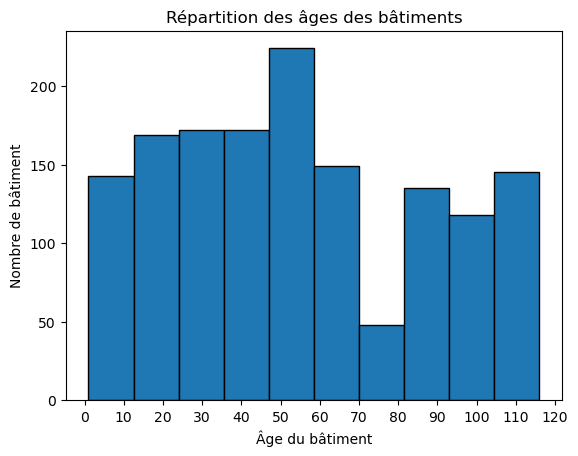

In [55]:
# Déterminons dans un premier temps l'âge du bâtiment
df_cleaned['âge'] = 2016 - df_cleaned['YearBuilt']

# Regardons les âges des bâtiments
plt.figure()
plt.hist(df_cleaned['âge'], bins=10, edgecolor='k')
plt.xlabel('Âge du bâtiment')
plt.xticks(range(0, 121, 10))
plt.ylabel('Nombre de bâtiment')
plt.title('Répartition des âges des bâtiments')
plt.show()

On voit qu'en prennant 10 bins on pourrait classer les bâtiments par intervalles de 10 ans.

In [56]:
print("L'année minimale est:", df_cleaned['YearBuilt'].min())
print("L'année maximale est:", df_cleaned['YearBuilt'].max())

L'année minimale est: 1900
L'année maximale est: 2015


In [57]:
# Création de la variable 'EraBuild' avec la fonction pour déterminer l'époque 'intervalle_age'
df_cleaned['âge'] = df_cleaned['YearBuilt'].map(époque)
df_cleaned.rename(columns={'âge': 'EraBuild'}, inplace=True)
df_cleaned = df_cleaned.drop(columns='YearBuilt').reset_index(drop=True)

df_cleaned.EraBuild.value_counts()

1960    204
1920    156
1950    156
1980    151
2000    148
1970    143
1990    141
1900    139
1910     91
1940     67
2010     44
1930     35
Name: EraBuild, dtype: int64

In [58]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1475 non-null   object 
 1   Neighborhood                     1475 non-null   object 
 2   NumberofBuildings                1475 non-null   float64
 3   NumberofFloors                   1475 non-null   int64  
 4   PropertyGFATotal                 1475 non-null   int64  
 5   PropertyGFAParking               1475 non-null   int64  
 6   LargestPropertyUseType           1475 non-null   object 
 7   LargestPropertyUseTypeGFA        1475 non-null   float64
 8   SecondLargestPropertyUseType     1475 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1475 non-null   float64
 10  ThirdLargestPropertyUseType      1475 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1475 non-null   float64
 12  ENERGYSTARScore     

### 3.4 Création d'un ratio d'utilisation pour SteamUse, Electricity et NaturalGas <a class="anchor" id="3_4"></a>

Notre objectif ici est de supprimer les variables qui indiquent la consommation énergétique des bâtiments pour éviter le data leakage.

Cependant, on va créer une variable de ratio pour chacune des énergies et cela permettra de savoir quelle énergie est la plus utilisée pour un bâtiment. Cela est envisageable car nous aurons au moins à notre disposition le premier relevé de référence pour les données des futurs bâtiments.

In [59]:
# Calculons l'utilisation totale
df_cleaned['Total_energy'] = df_cleaned['SteamUse(kBtu)']+df_cleaned['Electricity(kBtu)']+df_cleaned['NaturalGas(kBtu)']

# Calculons les différents ratio
df_cleaned['SteamUse_Ratio'] = df_cleaned['SteamUse(kBtu)']/df_cleaned['Total_energy']*100
df_cleaned['ElectricityUse_Ratio'] = df_cleaned['Electricity(kBtu)']/df_cleaned['Total_energy']*100
df_cleaned['NaturalGasUse_Ratio'] = df_cleaned['NaturalGas(kBtu)']/df_cleaned['Total_energy']*100

In [60]:
# Suppression des variables qui ne sont plus utiles
df_cleaned = df_cleaned.drop(columns=['SteamUse(kBtu)', 'Electricity(kBtu)', 
                                      'NaturalGas(kBtu)', 'Total_energy']).reset_index(drop=True)

# Vérifions les dimensions
print('Dimension du jeu de données :', df_cleaned.shape)

Dimension du jeu de données : (1475, 19)


In [61]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1475 non-null   object 
 1   Neighborhood                     1475 non-null   object 
 2   NumberofBuildings                1475 non-null   float64
 3   NumberofFloors                   1475 non-null   int64  
 4   PropertyGFATotal                 1475 non-null   int64  
 5   PropertyGFAParking               1475 non-null   int64  
 6   LargestPropertyUseType           1475 non-null   object 
 7   LargestPropertyUseTypeGFA        1475 non-null   float64
 8   SecondLargestPropertyUseType     1475 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1475 non-null   float64
 10  ThirdLargestPropertyUseType      1475 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1475 non-null   float64
 12  ENERGYSTARScore     

### 3.5 Identification des variables catégorielles <a class="anchor" id="3_5"></a>

In [62]:
# Il faut classer les variables
variables_quantitatives = df_cleaned.select_dtypes(include=['float64', 'int64'])
variables_quantitatives = variables_quantitatives.loc[:, ~variables_quantitatives.columns.str.contains('TARGET')]
variables_quantitatives = variables_quantitatives.columns.tolist()

variables_TARGET = df_cleaned.columns[df_cleaned.columns.str.contains('TARGET')].tolist()

variables_qualitatives = df_cleaned.select_dtypes(include=['object', 'bool']).columns.to_list()

In [63]:
variables_quantitatives

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'EraBuild',
 'SteamUse_Ratio',
 'ElectricityUse_Ratio',
 'NaturalGasUse_Ratio']

In [64]:
variables_TARGET

['TARGET_SiteEnergyUse(kBtu)', 'TARGET_TotalGHGEmissions']

In [65]:
variables_qualitatives

['PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

## 4. Analyse exploratoire <a class="anchor" id="4"></a>

### 4.1 Distribution des variables quantitatives <a class="anchor" id="4_1"></a>

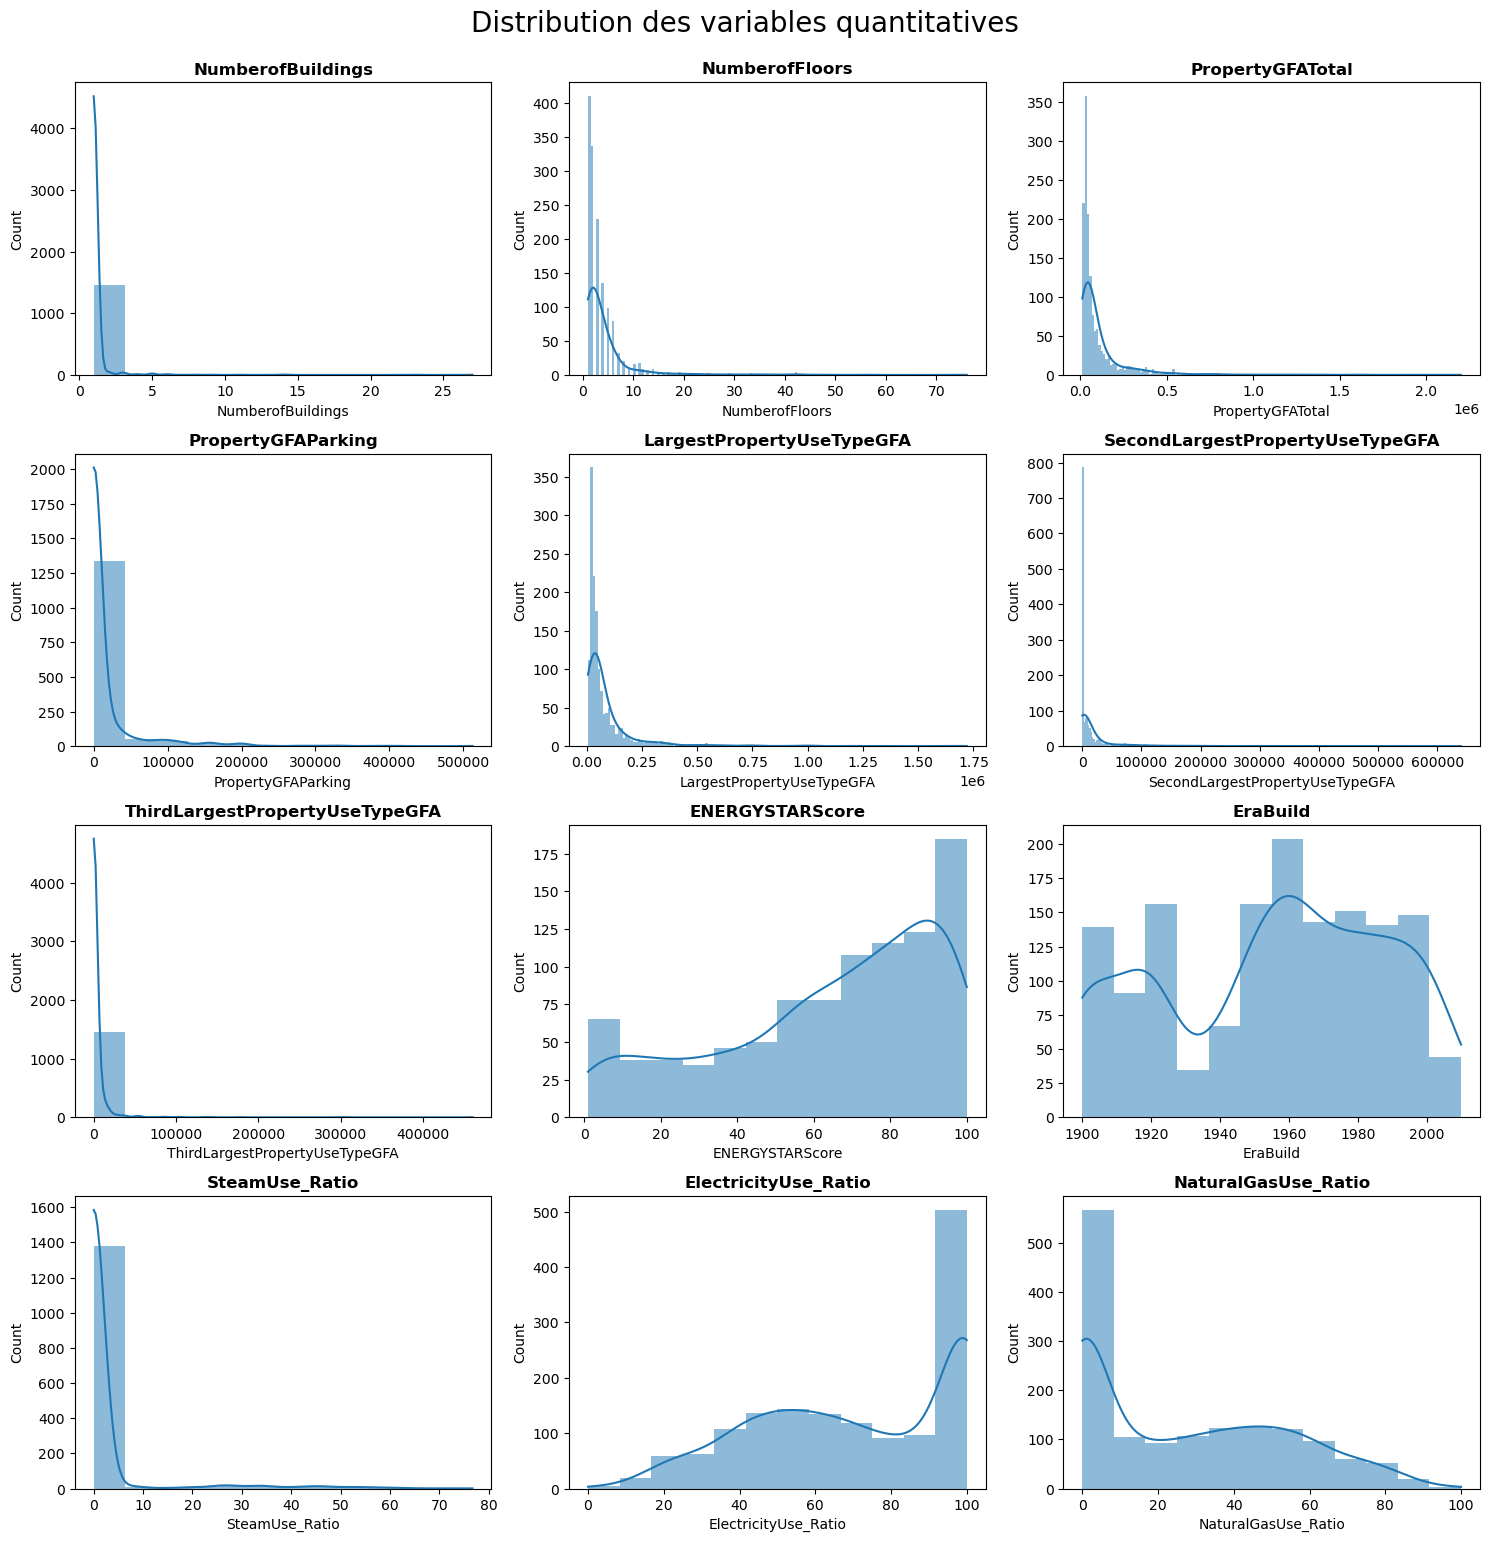

In [66]:
# Affichons la distribution de chaque variable quantitative
plt.figure(figsize=(15,15))

for i, colonne in enumerate(df_cleaned[variables_quantitatives].columns):
    plt.subplot(4, 3, i+1)
    sns.histplot(df_cleaned[colonne], kde=True, edgecolor='none')
    plt.title(colonne,fontweight='bold')

plt.tight_layout()
plt.suptitle('Distribution des variables quantitatives', fontsize=20, y=1.025)
plt.show()

On peut voir que les variables ne suivent pas une loi normale, la forme des courbes n'est pas gaussienne.

Il faudra donc normaliser/ standardiser les données afin d'obtenir de meilleurs prédictions.

### 4.2 Distribution des variables target <a class="anchor" id="4_2"></a>

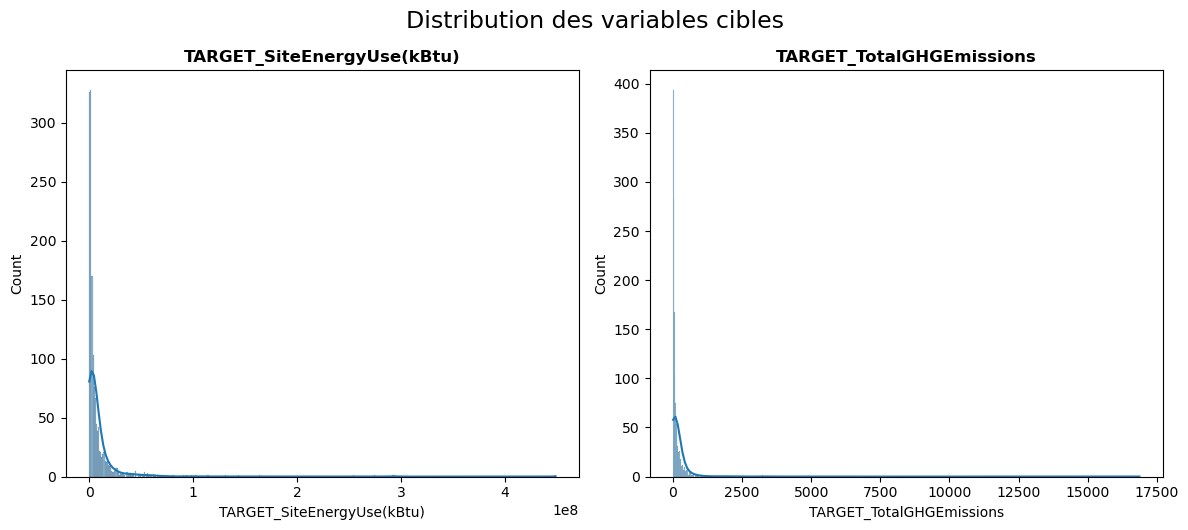

In [67]:
# Affichons la distribution de chaque target
plt.figure(figsize=(12,5))

for i, colonne in enumerate(df_cleaned[variables_TARGET].columns):
    plt.subplot(1, 2, i+1)
    sns.histplot(df_cleaned[colonne], kde=True)
    plt.title(colonne, fontweight='bold')

plt.tight_layout()
plt.suptitle('Distribution des variables cibles', fontsize=17, y=1.05)
plt.show()

### 4.3 Répartition des variables catégorielles <a class="anchor" id="4_3"></a>

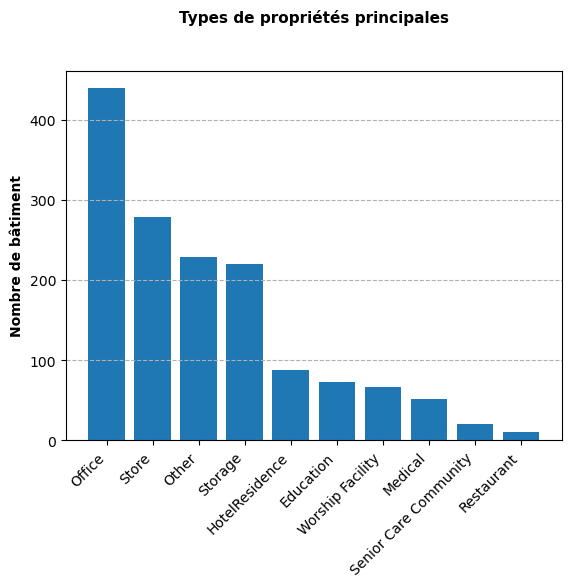

In [68]:
# Compter le nombre de bâtiments par PrimaryPropertyType
counts = df_cleaned['PrimaryPropertyType'].value_counts()

# Création d'un diagramme en barre
plt.bar(counts.index, counts)
plt.title('Types de propriétés principales', pad=35, fontsize=11, fontweight='bold')
plt.ylabel('Nombre de bâtiment', fontweight='bold')
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')

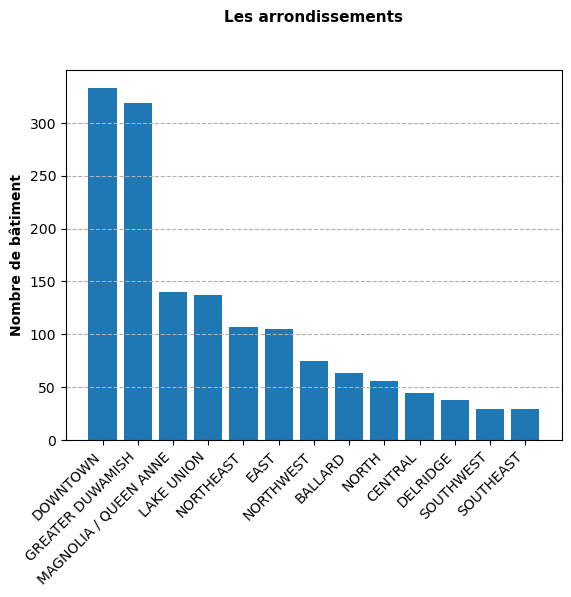

In [69]:
# Compter le nombre de bâtiments par arrondissements
counts = df_cleaned['Neighborhood'].value_counts()

# Création d'un diagramme en barre
plt.bar(counts.index, counts)
plt.title('Les arrondissements', pad=35, fontsize=11, fontweight='bold')
plt.ylabel('Nombre de bâtiment', fontweight='bold')
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')

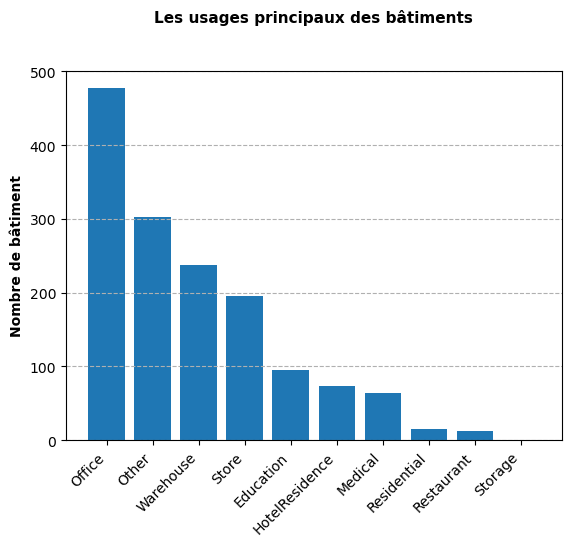

In [70]:
# Compter le nombre de bâtiments par usages principaux
counts = df_cleaned['LargestPropertyUseType'].value_counts()

# Création d'un diagramme en barre
plt.bar(counts.index, counts)
plt.title('Les usages principaux des bâtiments', pad=35, fontsize=11, fontweight='bold')
plt.ylabel('Nombre de bâtiment', fontweight='bold')
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')

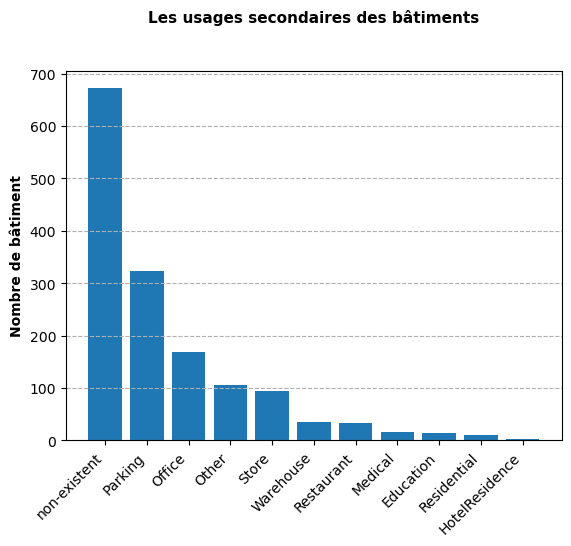

In [71]:
# Compter le nombre de bâtiments par usages secondaires
counts = df_cleaned['SecondLargestPropertyUseType'].value_counts()

# Création d'un diagramme en barre
plt.bar(counts.index, counts)
plt.title('Les usages secondaires des bâtiments', pad=35, fontsize=11, fontweight='bold')
plt.ylabel('Nombre de bâtiment', fontweight='bold')
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')

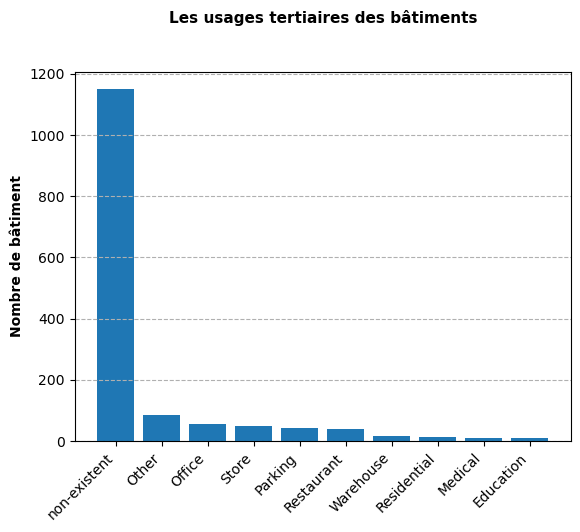

In [72]:
# Compter le nombre de bâtiments par usages tertiaires
counts = df_cleaned['ThirdLargestPropertyUseType'].value_counts()

# Création d'un diagramme en barre
plt.bar(counts.index, counts)
plt.title('Les usages tertiaires des bâtiments', pad=35, fontsize=11, fontweight='bold')
plt.ylabel('Nombre de bâtiment', fontweight='bold')
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y', linestyle = 'dashed')

### 4.4 Matrice des corrélations <a class="anchor" id="4_4"></a>

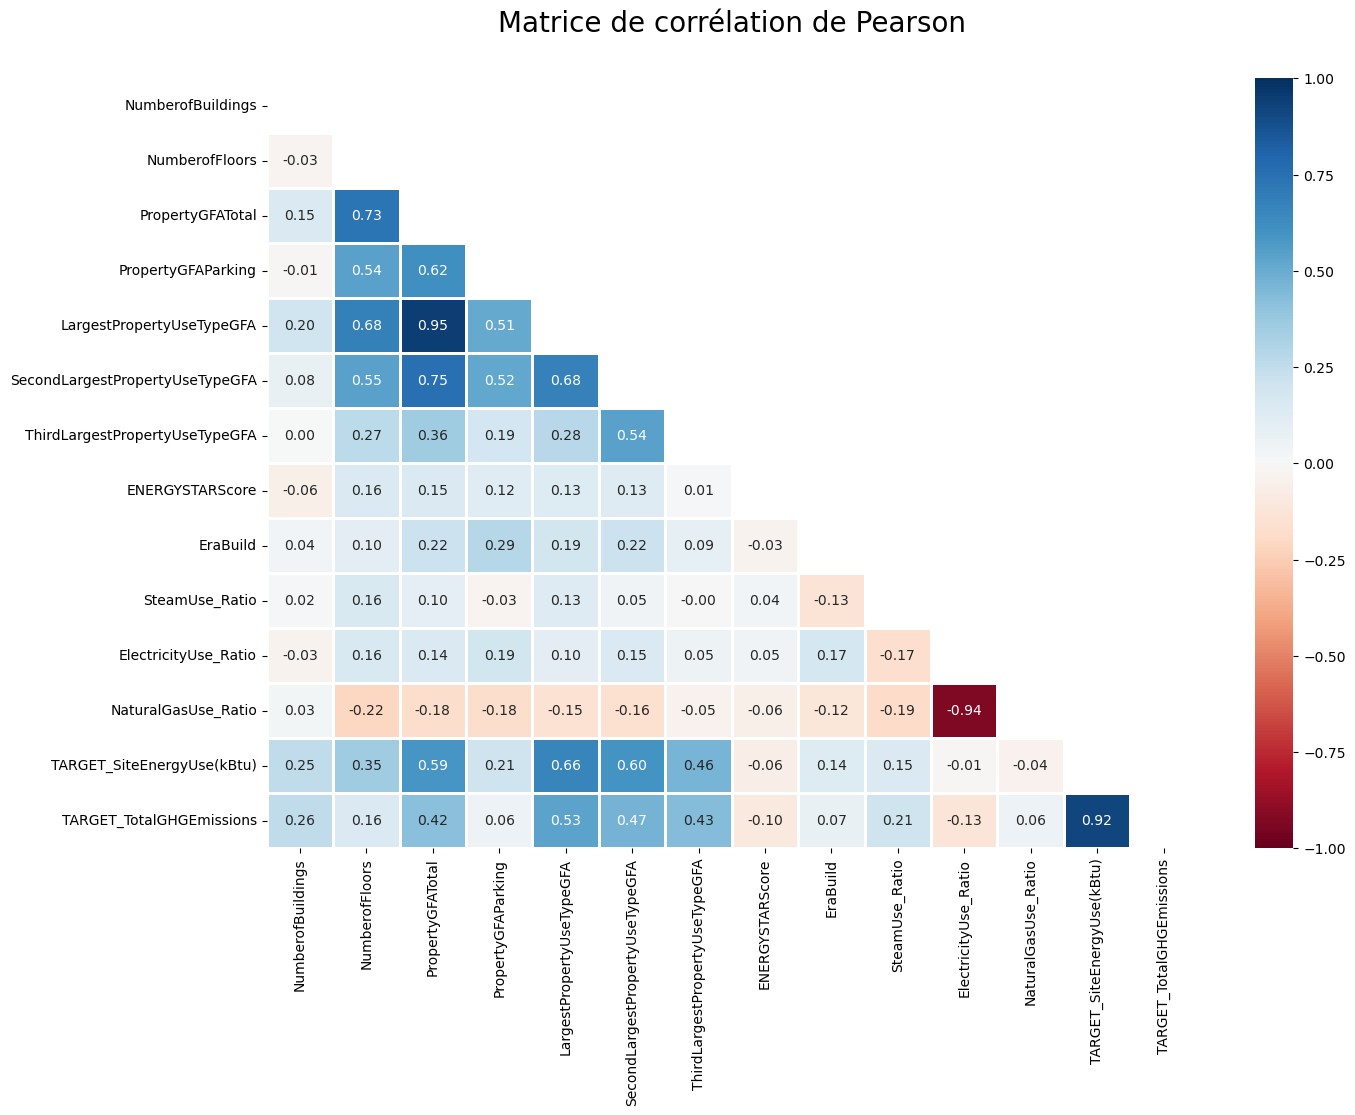

In [73]:
# Regardons pour les variables quantitatives et variables cibles
variables = variables_quantitatives + variables_TARGET

# Matrice de corrélation de Pearson
mask = np.triu(np.ones_like(df_cleaned[variables].corr(), dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(df_cleaned[variables].corr(), mask=mask, center=0, cmap='RdBu',
            linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de corrélation de Pearson', fontsize=20, y=1.05)
plt.show()

## 5. Export du fichier csv <a class="anchor" id="5"></a>

In [74]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1475 non-null   object 
 1   Neighborhood                     1475 non-null   object 
 2   NumberofBuildings                1475 non-null   float64
 3   NumberofFloors                   1475 non-null   int64  
 4   PropertyGFATotal                 1475 non-null   int64  
 5   PropertyGFAParking               1475 non-null   int64  
 6   LargestPropertyUseType           1475 non-null   object 
 7   LargestPropertyUseTypeGFA        1475 non-null   float64
 8   SecondLargestPropertyUseType     1475 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1475 non-null   float64
 10  ThirdLargestPropertyUseType      1475 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1475 non-null   float64
 12  ENERGYSTARScore     

In [75]:
df_cleaned.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TARGET_SiteEnergyUse(kBtu),TARGET_TotalGHGEmissions,EraBuild,SteamUse_Ratio,ElectricityUse_Ratio,NaturalGasUse_Ratio
0,HotelResidence,DOWNTOWN,1.0,12,88434,0,HotelResidence,88434.0,non-existent,0.0,non-existent,0.0,60.0,7226362.5,249.98,1920,27.730164,54.605997,17.663840
1,HotelResidence,DOWNTOWN,1.0,11,103566,15064,HotelResidence,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8387933.0,295.86,1990,0.000000,38.660907,61.339093
2,HotelResidence,DOWNTOWN,1.0,41,956110,196718,HotelResidence,756493.0,non-existent,0.0,non-existent,0.0,43.0,72587024.0,2089.28,1960,29.711310,68.230746,2.057944
3,HotelResidence,DOWNTOWN,1.0,10,61320,0,HotelResidence,61320.0,non-existent,0.0,non-existent,0.0,56.0,6794584.0,286.43,1920,32.591348,40.751933,26.656720
4,HotelResidence,DOWNTOWN,1.0,18,175580,62000,HotelResidence,123445.0,Parking,68009.0,Other,0.0,75.0,14172606.0,505.01,1970,0.000000,37.880171,62.119829


In [76]:
# Exporter le Dataframe en csv
df_cleaned.to_csv('df_cleaned.csv', index = False)